In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

import mne
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper
from utils import make__raw_and_epochs

%matplotlib qt
mne.set_log_level("WARNING")
raw_left, raw_right, epochs_left, epochs_right = make__raw_and_epochs(subject_number=1, set_average_reference=True, filter=(0.5,45), baseline = None)

freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test
epochs = mne.concatenate_epochs([epochs_left, epochs_right]).pick(["C3", "C4"])

# Do ERD/ERS map

In [7]:
tmin, tmax = -1, 4
tfr = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
event_ids = dict(imagery_left=1, imagery_right=2)
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 3, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 1]}
    )
    fig.canvas.manager.set_window_title(f"ERDS map ({event})")
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

### Calculate ERD/ERS magnitude

In [3]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "mu": 13, "beta": 35, "gamma": 140}
df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["mu"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:
df["channel"] = df["channel"].cat.reorder_categories(("C3", "C4"), ordered=True)

g = sns.FacetGrid(df, col="band", row="condition", margin_titles=True)
g.figure.canvas.manager.set_window_title(f"ERDS Activation Magnitude")
g.figure.suptitle(f"ERDS Activation Magnitude")
g.map(sns.lineplot, "time", "value", "channel", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

# Do ERD/ERS map with ICA

### Do ICA

In [5]:
# set default log level
mne.set_log_level("WARNING")
raw_left, raw_right, epochs_left, epochs_right = make__raw_and_epochs(
    subject_number=1,
    set_average_reference=True,
    filter=(0.5,45),
    baseline=None,
    reject=dict(eeg=20e-6),
)

epochs = mne.concatenate_epochs([epochs_left, epochs_right])
ica = mne.preprocessing.ICA(n_components=15, random_state=97)
ica.fit(epochs)
ica.exclude = [0]
epochs_clean = ica.apply(epochs).pick(["C3", "C4"])

### ERDS Map

In [9]:
tmin, tmax = -1, 4
tfr = tfr_multitaper(
    epochs_clean,
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
event_ids = dict(imagery_left=1, imagery_right=2)
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 3, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 1]}
    )
    fig.canvas.manager.set_window_title(f"ERDS map ({event}) after ICA")
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs_clean.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event}) after ICA")
    plt.show()

### Do ERD/ERS magnitude with ICA

In [8]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "mu": 13, "beta": 35, "gamma": 140}
df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["mu"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:
df["channel"] = df["channel"].cat.reorder_categories(("C3", "C4"), ordered=True)

g = sns.FacetGrid(df, col="band", row="condition", margin_titles=True)
g.figure.canvas.manager.set_window_title(f"ERDS Activation Magnitude after ICA")
g.figure.suptitle(f"ERDS Activation Magnitude after ICA")
g.map(sns.lineplot, "time", "value", "channel", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

# Global Field Power

In [ ]:
import matplotlib.pyplot as plt
from mne.baseline import rescale
from mne.datasets import somato
from mne.stats import bootstrap_confidence_interval
import pymatreader

iter_freqs = [("Theta", 4, 7), ("Alpha", 8, 12), ("Beta", 13, 25), ("Gamma", 30, 45)]
frequency_map_left = list()
frequency_map_right = list()

rawdata = pymatreader.read_mat("data/s" + str(1).zfill(2) + ".mat")
imagery_event = rawdata["eeg"]["imagery_event"]
event_id_left = {"imagery_left": 1}
event_id_right = {"imagery_right": 2}
event_indexes = []
for i in range(len(imagery_event)):
    if imagery_event[i] == 1:
        event_indexes.append(i)
events_left = np.array(
    [event_indexes, [0] * len(event_indexes), [1] * len(event_indexes)]
).T
events_right = np.array(
    [event_indexes, [0] * len(event_indexes), [2] * len(event_indexes)]
).T


ica_left = mne.preprocessing.ICA(n_components=15, random_state=97)
ica_left.fit(raw_left)
ica_left.exclude = [0]
raw_l_clean = ica_left.apply(raw_left)

ica_right = mne.preprocessing.ICA(n_components=15, random_state=97)
ica_right.fit(raw_right)
ica_right.exclude = [0]
raw_r_clean = ica_right.apply(raw_right)
for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    raw_l = raw_l_clean.copy()  # .pick(["C3", "C4"])
    raw_r = raw_r_clean.copy()  # .pick(["C3", "C4"])
    # raw = mne.concatenate_raws([raw_left, raw_right])
    # raw.pick(picks=["C3", "C4"])  # we just look at gradiometers
    # raw.load_data()

    # bandpass filter
    raw_l.filter(
        fmin,
        fmax,
        n_jobs=None,  # use more jobs to speed up.
        l_trans_bandwidth=1,  # make sure filter params are the same
        h_trans_bandwidth=1,
    )  # in each band and skip "auto" option.
    raw_r.filter(
        fmin,
        fmax,
        n_jobs=None,  # use more jobs to speed up.
        l_trans_bandwidth=1,  # make sure filter params are the same
        h_trans_bandwidth=1,
    )
    # epoch
    epochs_left = mne.Epochs(
        raw_l,
        events_left,
        preload=True,
        tmin=-2,
        tmax=5,
        event_id=event_id_left,
        baseline=None,
        reject=dict(eeg=20e-6),
    )
    epochs_right = mne.Epochs(
        raw_r,
        events_right,
        preload=True,
        tmin=-2,
        tmax=5,
        event_id=event_id_right,
        baseline=None,
        reject=dict(eeg=20e-6),
    )
    # remove evoked response
    epochs_left.subtract_evoked()
    epochs_right.subtract_evoked()

    # get analytic signal (envelope)
    epochs_left.apply_hilbert(envelope=True)
    epochs_right.apply_hilbert(envelope=True)
    frequency_map_left.append(((band, fmin, fmax), epochs_left.average()))
    frequency_map_right.append(((band, fmin, fmax), epochs_right.average()))
    del epochs_left, epochs_right
del raw_l, raw_r

In [ ]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x**2, axis=0)


# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.colormaps["winter_r"](np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
    frequency_map_left, colors, axes.ravel()[::-1]
):
    times = average.times  # * 1e3
    gfp = np.sum(average.data**2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle="--", color="grey", linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(
        average.data, random_state=0, stat_fun=stat_fun
    )
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel("GFP")
    ax.annotate(
        "%s (%d-%dHz)" % (freq_name, fmin, fmax),
        xy=(0.95, 0.8),
        horizontalalignment="right",
        xycoords="axes fraction",
    )
    ax.set_xlim(-1, 3)
    # ax.set_ylim(-2e-12, np.max(gfp)/3)

axes.ravel()[-1].set_xlabel("Time [ms]")

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.colormaps["winter_r"](np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
    frequency_map_right, colors, axes.ravel()[::-1]
):
    times = average.times * 1e3
    gfp = np.sum(average.data**2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle="--", color="grey", linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(
        average.data, random_state=0, stat_fun=stat_fun
    )
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel("GFP")
    ax.annotate(
        "%s (%d-%dHz)" % (freq_name, fmin, fmax),
        xy=(0.95, 0.8),
        horizontalalignment="right",
        xycoords="axes fraction",
    )
    ax.set_xlim(-1000, 3000)
    # ax.set_ylim(np.min(gfp)*8, np.max(gfp)/3)

axes.ravel()[-1].set_xlabel("Time [ms]")

# Plot power of mu band

### 1) Do ICA

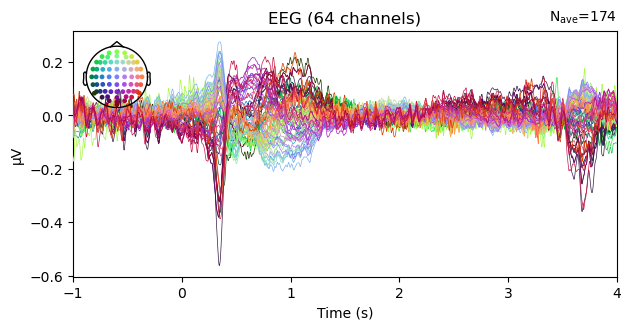

In [20]:
raw_left, raw_right, epochs_left, epochs_right = make__raw_and_epochs(subject_number=1, set_average_reference=True, filter=(0.5,45), baseline = None, reject=dict(eeg=20e-6))
epochs = mne.concatenate_epochs([epochs_left, epochs_right])
ica = mne.preprocessing.ICA(n_components=15, random_state=97)
ica.fit(epochs)
ica.plot_components()
ica.plot_sources(epochs, title="ICA sources")
ica.exclude = [0]
# epochs.plot(butterfly=True)
epochs.crop(-1, 4).average()

epochs.average().plot(spatial_colors=True)
epochs_clean = ica.apply(epochs)
epochs_clean.average().plot(spatial_colors=True)

### Extract mu band


In [ ]:
epochs.filter(8,13).baseline(-0.1,-0.2)

### 2) calculate power of mu band for each epoch

In [21]:
motor_events = ["imagery_left", "imagery_right"]
fig, axes = plt.subplots(
    nrows=1, ncols=2, layout="constrained", sharey=True, figsize=(10, 5)
)
for motor_event, ax in zip(motor_events, axes):
    epochs[motor_event].average().plot(
        spatial_colors=True,
        axes = ax,
        titles=motor_event,
    )

epochs_C3_C4 = epochs.copy().pick(["C3", "C4"])
motor_events = ["imagery_left", "imagery_right"]
fig, axes = plt.subplots(
    nrows=1, ncols=2, layout="constrained", sharey=True, figsize=(10, 5)
)
for motor_event, ax in zip(motor_events, axes):
    epochs_C3_C4[motor_event].average().plot(
        spatial_colors=True,
        axes = ax,
        titles=motor_event,
    )